<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/NB11.%20Medical%20Instance%20Segmentation%20with%20Mask%20RCNN%20Custom%20Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Instance Segmentation with Mask RCNN Custom Finetuning.


## 1. Introduction

Mask R-CNN, an extension of [Faster R-CNN](http://paperswithcode.com/method/faster-r-cnn), enhances its predecessor's capabilities by incorporating a dedicated branch for predicting instance masks alongside the existing bounding box recognition mechanism. This modification enables Mask R-CNN to perform both object detection and pixel-level segmentation within a unified framework, making it a versatile tool for tasks requiring precise object delineation.

Faster R-CNN, initially designed primarily for accurate object localization using region proposal networks (RPNs) and [RoIPool](http://paperswithcode.com/method/roi-pooling) for feature extraction, faced challenges in maintaining pixel-to-pixel alignment due to its coarse spatial quantization approach. This limitation becomes particularly apparent in tasks like instance segmentation, where exact spatial fidelity is critical.

To overcome this, Mask R-CNN introduces [RoIAlign](http://paperswithcode.com/method/roi-align), a refined operation that preserves precise spatial locations during feature extraction from region of interest (RoI) proposals. By eliminating the quantization step present in RoIPool, RoIAlign ensures that the features used for mask prediction align accurately with the corresponding regions in the input image, thereby improving segmentation quality significantly.

### Dataset Overview: NuInsSeg

The [**NuInsSeg dataset**](https://www.kaggle.com/datasets/ipateam/nuinsseg/data) stands out as a comprehensive resource designed specifically for advancing semantic and instance segmentation tasks in histopathology. It comprises over 30,000 manually segmented nuclei originating from 31 different organs of human and mouse subjects, annotated from high-resolution H&E-stained whole slide images. These annotations serve as a foundational dataset for training and evaluating segmentation algorithms.

In addition to nuclei annotations, the dataset includes 665 image patches extracted from these whole slide images, encapsulating a wide range of tissue types and morphologies. This diversity ensures that segmentation models trained on NuInsSeg are robust and capable of handling various biological contexts.

One of the unique features of the NuInsSeg dataset is the provision of ambiguous area masks, which highlight regions where manual segmentation was deemed challenging or impractical. These masks offer insights into the complexities and nuances involved in real-world segmentation tasks, aiding in the development of more robust and generalizable segmentation algorithms.

Overall, the NuInsSeg dataset not only supports the development and benchmarking of instance segmentation algorithms but also contributes significantly to the advancement of automated histopathological analysis, potentially enhancing medical diagnostics and research outcomes.


---
**Install Kaggle API Library**

---

In [1]:
%pip install -q kaggle


---

**Upload your Kaggle API Key**

---

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


---

**Copy the API key to `~/.kaggle`**

---

In [3]:
# %%capture # util quieres capturar el output de la celda
%mkdir -p ~/.kaggle
%cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~

total 72
drwx------ 1 root root 4096 Jul 19 06:48 .
drwxr-xr-x 1 root root 4096 Jul 19 06:37 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Jul 17 13:49 .cache
drwx------ 4 root root 4096 Jul 17 13:49 .config
drwxr-xr-x 5 root root 4096 Jul 17 13:48 .ipython
drwx------ 1 root root 4096 Jul 17 13:49 .jupyter
drwxr-xr-x 2 root root 4096 Jul 19 06:48 .kaggle
drwxr-xr-x 2 root root 4096 Jul 19 06:37 .keras
drwx------ 3 root root 4096 Jul 17 13:16 .launchpadlib
drwxr-xr-x 1 root root 4096 Jul 17 13:49 .local
drwxr-xr-x 4 root root 4096 Jul 17 13:49 .npm
-rw-r--r-- 1 root root  161 Jul  9  2019 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf
-rw-r--r-- 1 root root  211 Jul 17 13:49 .wget-hsts


---
**List kaggle datasets nuiseng**

---

In [4]:
!kaggle datasets list -s "nuinsseg"

ref               title     size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------  --------  ----  -------------------  -------------  ---------  ---------------  
ipateam/nuinsseg  NuInsSeg   2GB  2023-06-12 14:49:00            826         15  0.875            


---

**Download ipateam/nuinsseg**

---


In [6]:
%%time
# Download the dataset from Kaggle

from  zipfile import ZipFile
import os

# First, ensure the 'dataset-Nuclei' directory exists

!mkdir -p ./dataset-Nuclei

# Download the dataset from Kaggle in dataset-Nuclei

!kaggle datasets download -d ipateam/nuinsseg -p ./dataset-Nuclei

# Unzip the dataset into the 'dataset-Nuclei' directory

with ZipFile('./dataset-Nuclei/nuinsseg.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset-Nuclei')

# or simply
#!unzip ./dataset-Nuclei/nuinsseg.zip -d ./dataset-Nuclei -q

# Remove the zip file after extraction (optional)

os.remove('./dataset-Nuclei/nuinsseg.zip')


Dataset URL: https://www.kaggle.com/datasets/ipateam/nuinsseg
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.51G/1.52G [00:16<00:00, 152MB/s]
100% 1.52G/1.52G [00:16<00:00, 99.8MB/s]
CPU times: user 16.3 s, sys: 7.66 s, total: 24 s
Wall time: 42 s


---
**List our directory dataset-Nuclei**

---


In [8]:
# Install Pip Tree globally

!sudo apt install tree -q


!tree --dirsfirst -L 2  "dataset-Nuclei"

Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
dataset-Nuclei
├── human bladder
│   ├── distance maps
│   ├── Imagj_zips
│   ├── label masks
│   ├── label masks modify
│   ├── mask binary
│   ├── mask binary without border
│   ├── mask binary without border erode
│   ├── nuclei border
│   ├── overlay_save_path
│   ├── stacked mask
│   ├── tissue images
│   ├── vague areas
│   ├── weighted_maps
│   └── weighted_maps_erode
├── human brain
│   ├── distance maps
│   ├── Imagj_zips
│   ├── label masks
│   ├── label masks modify
│   ├── mask binary
│   ├── mask binary without border
│   ├── mask binary without border erode
│   ├── nuclei border
│   ├── overlay_save_path
│   ├── stacked mask
│   ├── tissue images
│   ├── vague areas
│   ├── weighted_maps
│   └── weighted_maps_erode
├── human cardia
│   ├── distance maps
│   ├── Imagj_zips
│   ├── lab

## 2. Data Preparation


Clean up of the Nuclei dataset
Can be downloaded from: https://www.kaggle.com/datasets/ipateam/nuinsseg?resource=download

The dataset comes with a lot of subdirectories that can be very useful depending
on the task of your interest. For our Mask RCNN and Ultralytics training, we just
need the raw images and labeled masks that we will convert to appropriate formats.
So let us delete all unwanted data and keep only the raw images, binary masks
and label masks.

Keep the directories with names 'tissue images', 'mask binary without border', and 'label masks modify'

---

**Pruning innecesary subsdirectories**

---

In [9]:
import os
import shutil

base_directory = "dataset-Nuclei"
directories_to_keep = ['tissue images',
                       'mask binary without border']#,
                       #'label masks modify']

#Iterate through each subdirs in base dir
for root_dir in os.listdir(base_directory):
    root_path = os.path.join(base_directory,root_dir)
    if os.path.isdir(root_path):
        #  print(f"Processing: {root_path}")
        #List all subdirs inside the current root dir
        for sub_dir in os.listdir(root_path):
            sub_path = os.path.join(root_path, sub_dir)
            #If the subdirectory isn't in the keep list, delete it
            if os.path.isdir(sub_path) and sub_dir not in directories_to_keep:
                # print(f"Deleting: {sub_path}")
                shutil.rmtree(sub_path)
            elif os.path.isdir(sub_path):
                # print(f"Keeping: {sub_path}")
                pass



---


**List prunned directory**



---



In [10]:
!tree --dirsfirst -L 2  "dataset-Nuclei"

dataset-Nuclei
├── human bladder
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human brain
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human cardia
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human cerebellum
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human epiglottis
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human jejunum
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human kidney
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human liver
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human lung
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human melanoma
│   ├── label masks modify
│   ├── mask binary with

## 3. Displaying Images from Dataset

Next code selects a certain number of images from a directory containing images of `tissue`, calculates the appropriate layout for subplots based on the number of images, and displays the images in the subplots using matplotlib.

---

**Display some images from dataset**

---

Displaying images from dataset-Nuclei/human cerebellum/label masks modify


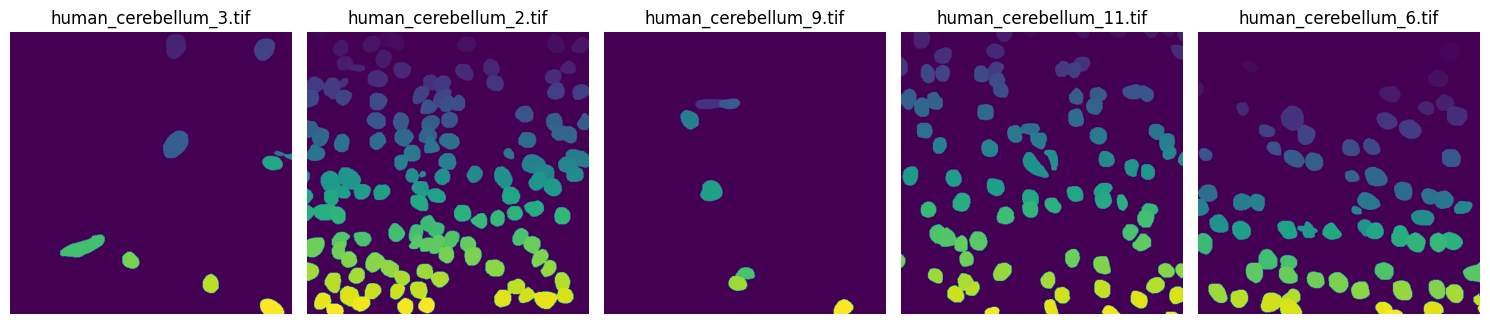

Displaying images from dataset-Nuclei/human cerebellum/mask binary without border


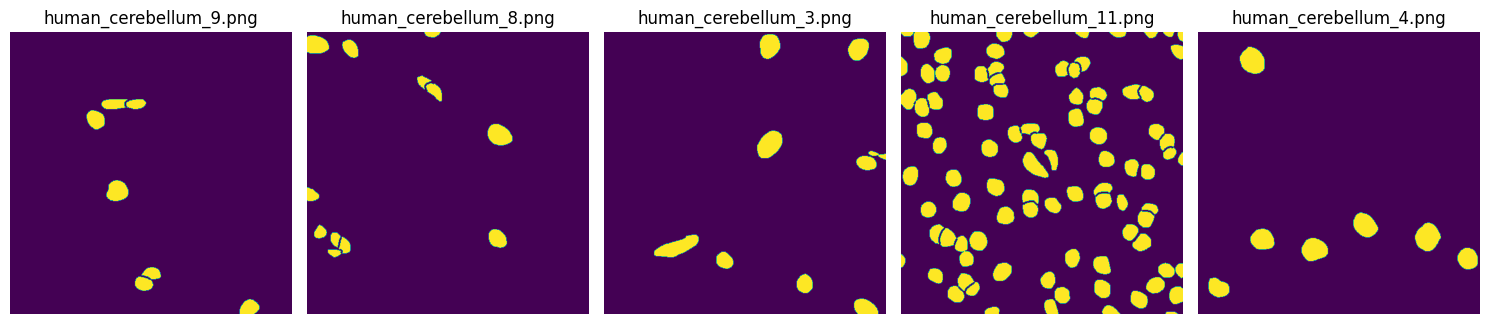

Displaying images from dataset-Nuclei/human cerebellum/tissue images


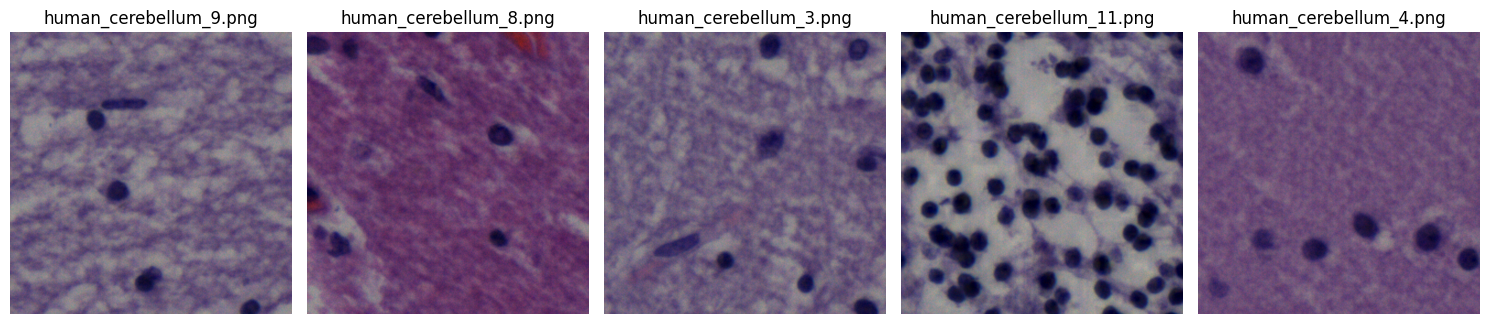

In [11]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing images
base_directory = "dataset-Nuclei"

# List of subdirectories in the base directory
subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# Select a random subdirectory from subdirectories
random_subdirectory = random.choice(subdirectories)
random_subdirectory_path = os.path.join(base_directory, random_subdirectory)

# List of sub-subdirectories in the random subdirectory
subsubdirectories = [d for d in os.listdir(random_subdirectory_path) if os.path.isdir(os.path.join(random_subdirectory_path, d))]

# Function to display images from a directory
def display_images_from_directory(directory, max_images=5):
    image_extensions = ['.tif', '.png']
    image_files = [f for f in os.listdir(directory) if any(f.endswith(ext) for ext in image_extensions)]

    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(image_files[:max_images]):  # Displaying up to max_images
        img_path = os.path.join(directory, image_file)
        img = Image.open(img_path)
        plt.subplot(1, max_images, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display images from each sub-subdirectory
for subsubdirectory in subsubdirectories:
    subsubdirectory_path = os.path.join(random_subdirectory_path, subsubdirectory)
    print(f"Displaying images from {subsubdirectory_path}")
    display_images_from_directory(subsubdirectory_path)


We need to convert Label Masks to Coco Json single file annotation. We will convert our labeled mask image annotations to coco json
format so they can be used in training Mask R-CNN.

For it we will use

The get_image_mask_pairs function traverses a data directory, finds all PNG images in directories that contain 'tissue images', and builds a list of their paths along with the paths of their corresponding masks, assuming the masks are in a parallel directory named 'label masks modify' and have a '.tif' extension. This function is useful for preparing pairs of image and mask data for further processing or analysis.



The mask_to_polygons function processes a binary mask to extract contours, reshapes these contours into polygons (a flat list of coordinates), and ensures that each polygon has a valid number of points. This is useful for converting segmentation masks into a format suitable for COCO annotations or other applications that require polygon representations of objects.

This code processes all images in the subdirectories and sub-subdirectories of the base directory, checks if they are binary, extracts polygons from the contours, and generates a coco.json file with the corresponding annotations.

---

**mask_to_polygons_to COCO.json**

---

In [20]:
%%time
import os
import json
import numpy as np
import cv2
from PIL import Image

# Directory containing images
base_directory = "dataset-Nuclei"

# List of subdirectories in the base directory
subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# Function to check if an image is binary
def is_binary_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_np = np.array(img)
    unique_values = np.unique(img_np)
    return len(unique_values) == 2 and set(unique_values).issubset({0, 255})

# Function to find contours in a binary image and convert them to polygons
def get_polygons_from_mask(mask_image):
    mask_np = np.array(mask_image)
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [contour.flatten().tolist() for contour in contours if len(contour) >= 3]
    return polygons

# Initialize COCO structure
coco_data = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "nucleus", "supercategory": "object"}]
}

annotation_id = 1

# Process each subdirectory and its sub-subdirectories
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(base_directory, subdirectory)
    subsubdirectories = [d for d in os.listdir(subdirectory_path) if os.path.isdir(os.path.join(subdirectory_path, d))]

    for subsubdirectory in subsubdirectories:
        subsubdirectory_path = os.path.join(subdirectory_path, subsubdirectory)
        image_files = [f for f in os.listdir(subsubdirectory_path) if any(f.endswith(ext) for ext in ['.tif', '.png'])]

        for image_file in image_files:
            img_path = os.path.join(subsubdirectory_path, image_file)
            img = Image.open(img_path).convert('L')  # Convert to grayscale

            if is_binary_image(img_path):
                img_np = np.array(img)
                height, width = img_np.shape
                polygons = get_polygons_from_mask(img_np)

                if polygons:
                    coco_data["images"].append({
                        "id": len(coco_data["images"]) + 1,
                        "file_name": image_file,
                        "height": height,
                        "width": width
                    })

                    for polygon in polygons:
                        coco_data["annotations"].append({
                            "id": annotation_id,
                            "image_id": len(coco_data["images"]),
                            "category_id": 1,
                            "segmentation": [polygon],
                            "area": cv2.contourArea(np.array(polygon).reshape((-1, 2))),
                            "bbox": cv2.boundingRect(np.array(polygon).reshape((-1, 2))),
                            "iscrowd": 0
                        })
                        annotation_id += 1

# Save the data in COCO JSON format
with open("coco_annotations.json", "w") as outfile:
    json.dump(coco_data, outfile, indent=4)

print("Conversion complete. File saved as coco_annotations.json")


Conversion complete. File saved as coco_annotations.json
CPU times: user 40 s, sys: 1.51 s, total: 41.5 s
Wall time: 45.7 s


## 4. Displaying annotations from Dataset


---

**Libraries and auxiliar functions**

---

In [25]:
import json
import os
import random
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Directory containing images
base_directory = "dataset-Nuclei"

# Function to get all sub-subdirectories from the base directory
def get_all_image_paths(base_directory):
    image_paths = {}
    subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(base_directory, subdirectory)
        subsubdirectories = [d for d in os.listdir(subdirectory_path) if os.path.isdir(os.path.join(subdirectory_path, d))]
        for subsubdirectory in subsubdirectories:
            subsubdirectory_path = os.path.join(subdirectory_path, subsubdirectory)
            image_files = [f for f in os.listdir(subsubdirectory_path) if any(f.endswith(ext) for ext in ['.tif', '.png'])]
            for image_file in image_files:
                image_path = os.path.join(subsubdirectory_path, image_file)
                image_paths[image_file] = image_path
    return image_paths

# Get all image paths
image_paths = get_all_image_paths(base_directory)


---

**Load COCO Annotations and Map Image IDs**

---

In [26]:
# Load COCO annotations
with open('coco_annotations.json') as f:
    coco_data = json.load(f)

# Create a dictionary to map image IDs to image data
image_id_to_data = {img['id']: img for img in coco_data['images']}


---

**Visualize Images and Annotations**

---

In [27]:
# Function to visualize a single image and its annotations
def visualize_image(image_data, annotations, ax):
    file_name = image_data['file_name']
    img_path = image_paths.get(file_name)

    if img_path is None:
        print(f"Image file {file_name} not found in any of the subdirectories.")
        return

    # Load the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

    # Overlay the annotations
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            polygon = np.array(ann['segmentation'][0]).reshape(-1, 2)
            poly = Polygon(polygon, facecolor='none', edgecolor='r')
            ax.add_patch(poly)

    ax.set_title(f"ID: {image_data['id']}")


---

**Randomly Select and Visualize 10 Images**

---

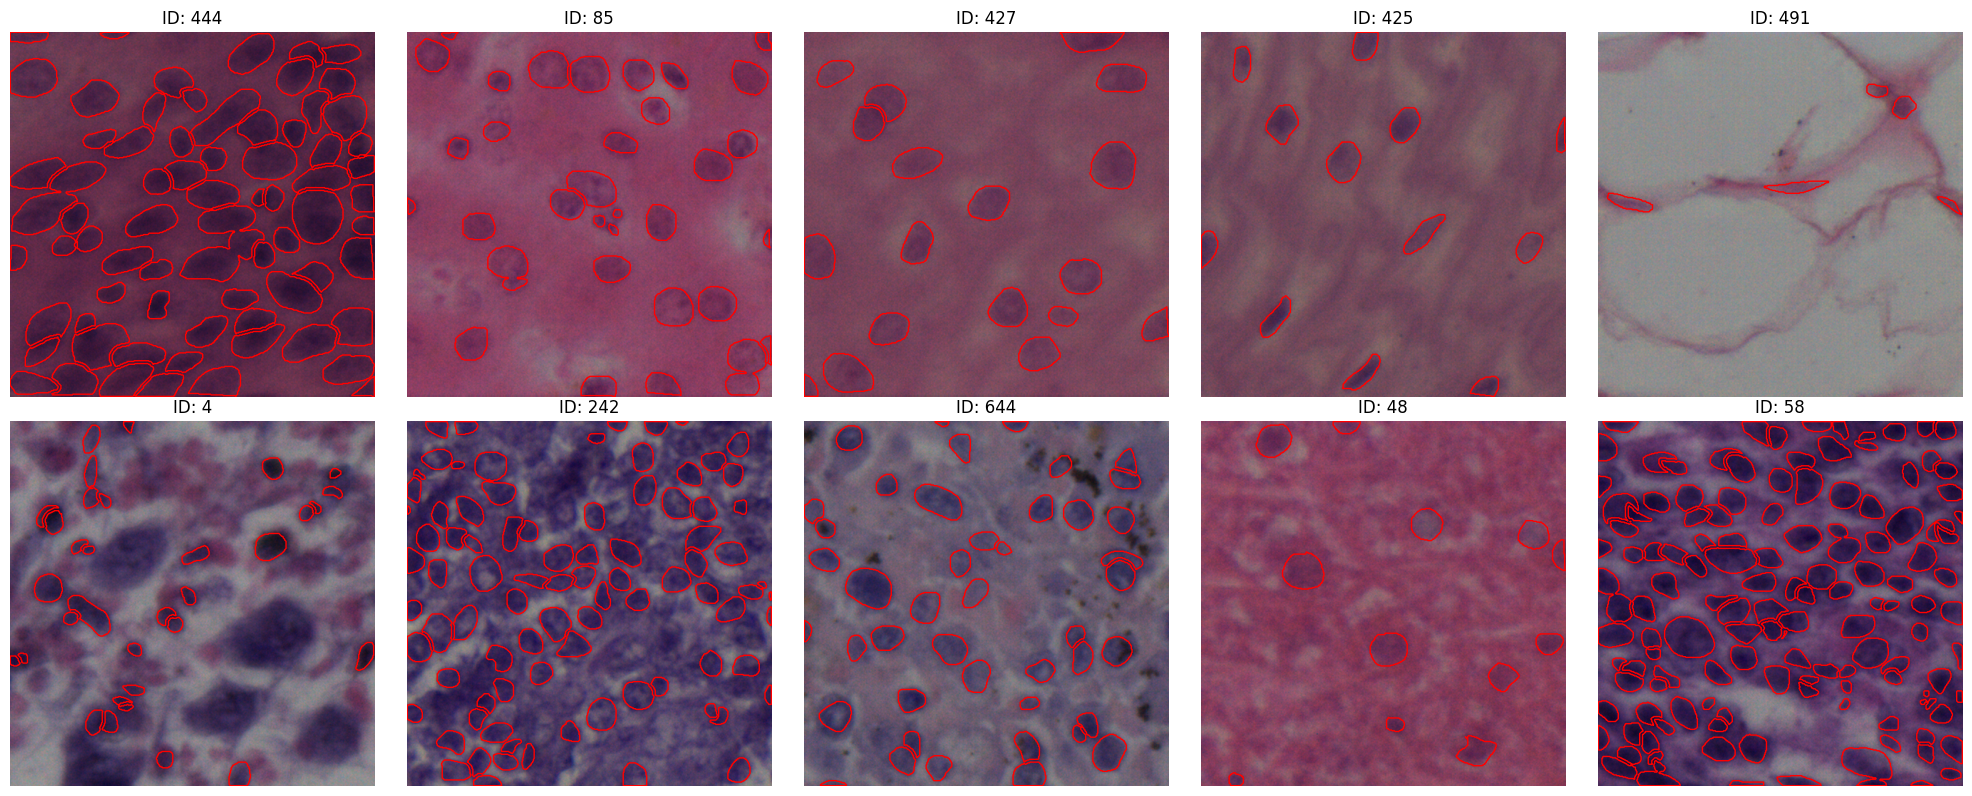

In [28]:
# Randomly select 10 images
random_images = random.sample(coco_data['images'], 10)

# Create a plot with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

# Visualize each selected image and its annotations
for ax, img_data in zip(axs, random_images):
    image_id = img_data['id']
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax)

plt.tight_layout()
plt.show()


---

**Print JSON File Lines**

---

In [31]:
# Print the first few lines of the coco_annotations.json file
with open('coco_annotations.json', 'r') as f:
    for _ in range(56):  # Adjust the number of lines as needed
        print(f.readline().strip())


{
"images": [
{
"id": 1,
"file_name": "human_melanoma_10.png",
"height": 512,
"width": 512
},
{
"id": 2,
"file_name": "human_melanoma_03.png",
"height": 512,
"width": 512
},
{
"id": 3,
"file_name": "human_melanoma_06.png",
"height": 512,
"width": 512
},
{
"id": 4,
"file_name": "human_melanoma_02.png",
"height": 512,
"width": 512
},
{
"id": 5,
"file_name": "human_melanoma_09.png",
"height": 512,
"width": 512
},
{
"id": 6,
"file_name": "human_melanoma_12.png",
"height": 512,
"width": 512
},
{
"id": 7,
"file_name": "human_melanoma_05.png",
"height": 512,
"width": 512
},
{
"id": 8,
"file_name": "human_melanoma_11.png",
"height": 512,
"width": 512
},
{
"id": 9,
"file_name": "human_melanoma_08.png",
"height": 512,
"width": 512
},


---

**Print Polygon Coordinates**

---

In [32]:
# Function to print the polygon coordinates for a random image
def print_polygon_coordinates(image_data, annotations):
    print(f"Image ID: {image_data['id']}, File Name: {image_data['file_name']}")
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            print(f"  Annotation ID: {ann['id']}, Polygon Coordinates: {ann['segmentation'][0]}")


In [33]:
# Print polygon coordinates for the 10 random images
for img_data in random_images:
    image_id = img_data['id']
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
    print_polygon_coordinates(img_data, annotations)

Image ID: 444, File Name: human_oesophagus_07.png
  Annotation ID: 17163, Polygon Coordinates: [511, 483, 510, 484, 509, 484, 508, 485, 507, 485, 499, 493, 499, 494, 498, 495, 497, 495, 492, 500, 491, 500, 488, 503, 487, 503, 487, 504, 486, 505, 484, 505, 484, 506, 483, 507, 482, 507, 479, 510, 507, 510, 508, 511, 511, 511]
  Annotation ID: 17164, Polygon Coordinates: [9, 476, 2, 483, 2, 485, 0, 487, 0, 496, 2, 498, 2, 499, 5, 502, 5, 503, 6, 504, 6, 505, 8, 507, 9, 507, 10, 508, 32, 508, 33, 507, 36, 507, 37, 506, 53, 506, 54, 505, 56, 505, 58, 503, 60, 503, 61, 502, 65, 502, 66, 501, 66, 500, 67, 499, 67, 497, 61, 491, 60, 491, 56, 487, 55, 487, 54, 486, 53, 486, 52, 485, 48, 485, 47, 484, 46, 484, 45, 483, 42, 483, 41, 482, 40, 482, 39, 481, 37, 481, 36, 480, 35, 480, 34, 479, 31, 479, 30, 478, 25, 478, 24, 477, 23, 477, 22, 476]
  Annotation ID: 17165, Polygon Coordinates: [301, 469, 300, 470, 296, 470, 295, 471, 293, 471, 292, 472, 285, 472, 284, 473, 283, 473, 282, 474, 280, 474,

## 4. Organize Image Data

---

**Split your images and annotations into training and validation sets.**

---

In [57]:
import json
import os
import random
from shutil import copyfile

# Create a dictionary to map file names to image IDs
file_name_to_id = {img['file_name']: img['id'] for img in coco_data['images']}

# Function to split the dataset into train and validation sets
def split_dataset(image_paths, split_ratio=0.8):
    image_files = list(image_paths.keys())
    random.shuffle(image_files)
    split_index = int(len(image_files) * split_ratio)
    train_files = image_files[:split_index]
    val_files = image_files[split_index:]
    return train_files, val_files

# Function to create directory structure
def create_directory_structure(base_directory, subdirectories):
    for subdirectory in subdirectories:
        train_dir = os.path.join(base_directory, 'train2017', subdirectory)
        val_dir = os.path.join(base_directory, 'val2017', subdirectory)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)

# Split the dataset into train and validation sets
train_files, val_files = split_dataset(image_paths, split_ratio=0.8)

# Create directories for train and validation sets
create_directory_structure(base_directory, [''])

# Copy images to corresponding directories
def copy_images(file_list, target_directory):
    for file_name in file_list:
        src_path = image_paths[file_name]
        dst_path = os.path.join(target_directory, file_name)
        copyfile(src_path, dst_path)

# Copy images
train_directory = os.path.join(base_directory, 'train2017')
val_directory = os.path.join(base_directory, 'val2017')

copy_images(train_files, train_directory)
copy_images(val_files, val_directory)


---

**Create COCO Annotation Files for Train and Validation Sets**

---

In [58]:
# Function to filter annotations based on image files
def filter_annotations(image_files):
    # Get image IDs for the given file names
    image_ids = {file_name_to_id[file_name] for file_name in image_files if file_name in file_name_to_id}

    # Filter annotations based on the image IDs
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in image_ids]

    # Filter images based on the file names
    images = [img for img in coco_data['images'] if img['file_name'] in image_files]

    return {'images': images, 'annotations': annotations}

# Create annotations for train and validation sets
train_annotations = filter_annotations(train_files)
val_annotations = filter_annotations(val_files)

# Define paths for the new COCO annotation files
train_annotation_path = 'train2017_coco_annotations.json'
val_annotation_path = 'val2017_coco_annotations.json'

# Save the annotations to JSON files
with open(train_annotation_path, 'w') as f:
    json.dump({
        'images': train_annotations['images'],
        'annotations': train_annotations['annotations'],
        'categories': coco_data['categories']
    }, f, indent=4)

with open(val_annotation_path, 'w') as f:
    json.dump({
        'images': val_annotations['images'],
        'annotations': val_annotations['annotations'],
        'categories': coco_data['categories']
    }, f, indent=4)


---
**Verify Directory and Annotation Files**

---

In [59]:
# Verify directory structure
def verify_directories(directories):
    for directory in directories:
        if not os.path.exists(directory):
            print(f"Directory {directory} does not exist.")

# Verify that the new directories were created
verify_directories([train_directory, val_directory])

# Verify annotation files
def verify_annotation_files(files):
    for file in files:
        if not os.path.isfile(file):
            print(f"File {file} does not exist.")

# Verify that annotation files were created
verify_annotation_files([train_annotation_path, val_annotation_path])


In [65]:
import os

# Define paths for the train and val directories
train_directory = base_directory+'/train2017'
val_directory = base_directory+'/val2017'

# Function to count files in a directory
def count_files(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Count files in train2017 and val2017
num_train_files = count_files(train_directory)
num_val_files = count_files(val_directory)

num_train_files, num_val_files


(1328, 788)

----
visualizar 10 imagenes de cada directorio para comprobar.


In [60]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.patches import Polygon

# Load COCO annotations for train and val sets
with open('train2017_coco_annotations.json') as f:
    train_coco_data = json.load(f)

with open('val2017_coco_annotations.json') as f:
    val_coco_data = json.load(f)

# Create dictionaries to map image file names to their data
train_file_name_to_data = {img['file_name']: img for img in train_coco_data['images']}
val_file_name_to_data = {img['file_name']: img for img in val_coco_data['images']}


In [61]:
# Function to visualize a single image and its annotations
def visualize_image(image_data, annotations, ax):
    file_name = image_data['file_name']
    img_path = os.path.join(base_directory, 'train2017' if 'train2017' in file_name else 'val2017', file_name)

    if not os.path.isfile(img_path):
        print(f"Image file {file_name} not found.")
        return

    # Load the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

    # Overlay the annotations
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            polygon = np.array(ann['segmentation'][0]).reshape(-1, 2)
            poly = Polygon(polygon, facecolor='none', edgecolor='r')
            ax.add_patch(poly)

    ax.set_title(f"ID: {image_data['id']}")


In [62]:
# Randomly select 5 images from each dataset
train_images = random.sample(train_coco_data['images'], 5)
val_images = random.sample(val_coco_data['images'], 5)

# Prepare annotations for the selected images
def get_annotations_for_images(images, coco_data):
    image_ids = {img['id'] for img in images}
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in image_ids]
    return annotations

train_annotations = get_annotations_for_images(train_images, train_coco_data)
val_annotations = get_annotations_for_images(val_images, val_coco_data)


Image file mouse_heart_16.png not found.
Image file mouse_kidney_04.png not found.
Image file human_melanoma_04.png not found.
Image file human_jejunum_02.png not found.


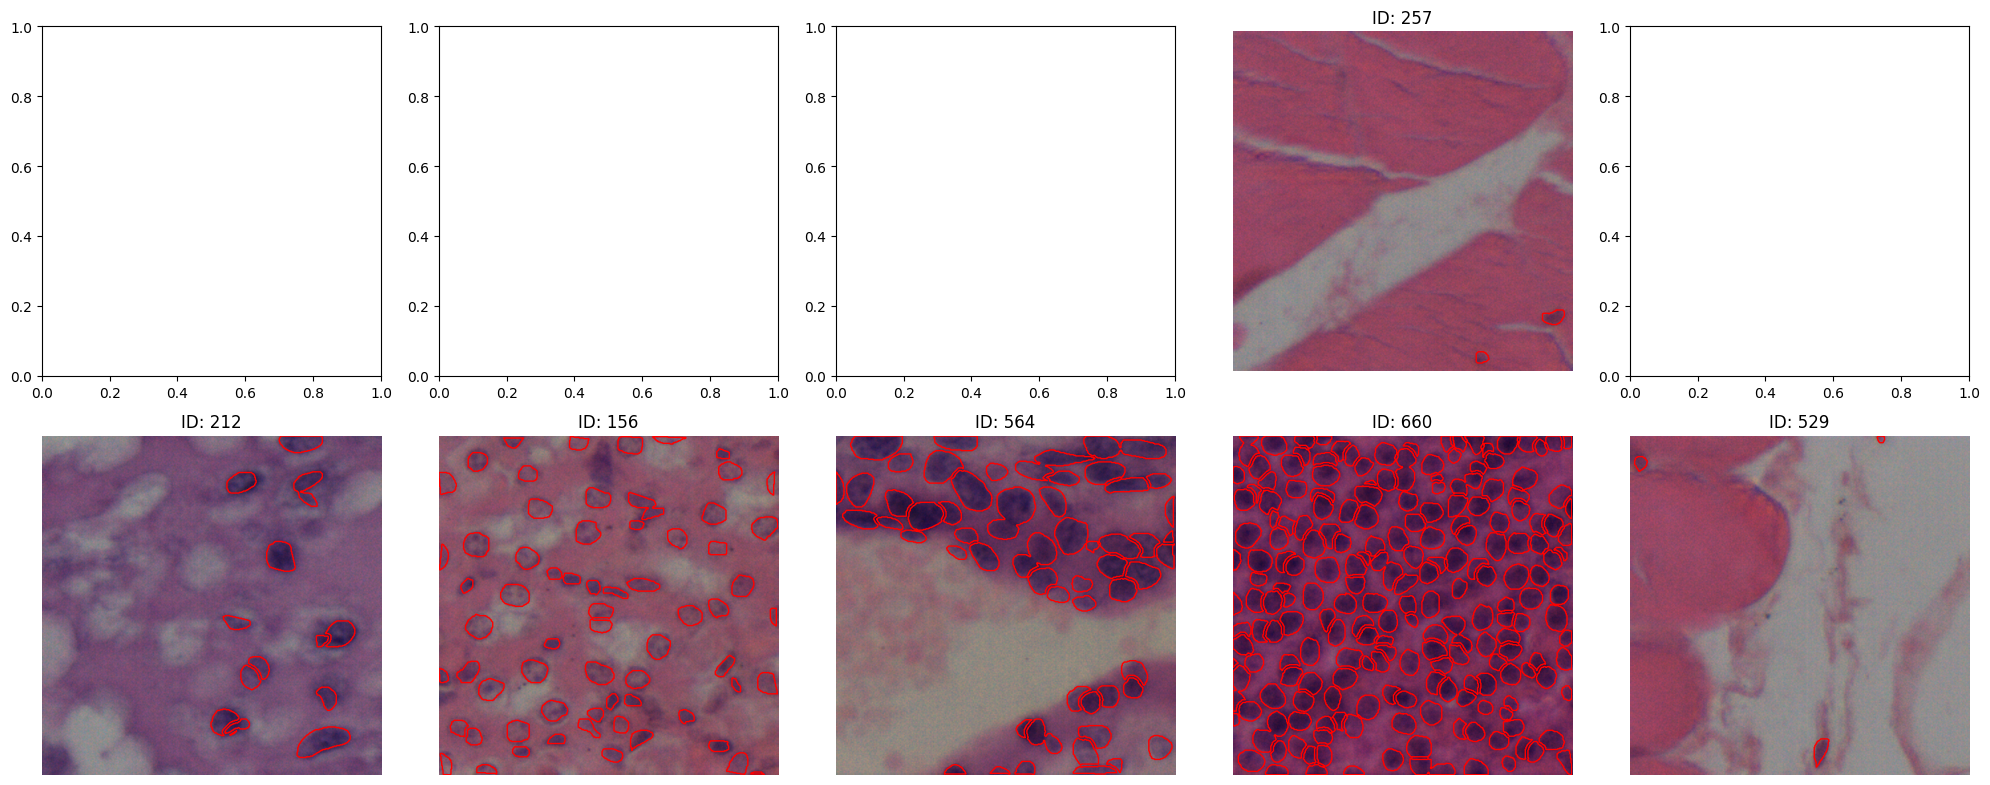

In [63]:
# Plot images from train and validation sets
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

# Plot train images
for ax, img_data in zip(axs[0], train_images):
    image_id = img_data['id']
    annotations = [ann for ann in train_annotations if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax)

# Plot val images
for ax, img_data in zip(axs[1], val_images):
    image_id = img_data['id']
    annotations = [ann for ann in val_annotations if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax)

plt.tight_layout()
plt.show()


------------------

In [ ]:
!pip install -q pycocotools

---

import os
import copy
import random
import json
import glob
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from   zipfile import ZipFile
import argparse
import shutil


from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.utils.data
from torch import nn
import torchvision


from torchvision import transforms as T

from pycocotools import mask as coco_mask
from pycocotools.coco import COCO


"""
Data Preparation


Clean up of the Nuclei dataset
Can be downloaded from: https://www.kaggle.com/datasets/ipateam/nuinsseg?resource=download

The dataset comes with a lot of subdirectories that can be very useful depending
on the task of your interest. For our Mask RCNN and Ultralytics training, we just
need the raw images and labeled masks that we will convert to appropriate formats.
So let us delete all unwanted data and keep only the raw images, binary masks
and label masks.

Keep the directories with names 'tissue images', 'mask binary without border', and 'label masks modify'

"""


def prune_subdirectories(base_dir,keep_dirs):
    #Iterate through each subdirs in base dir
    for root_dir in os.listdir(base_dir):
        root_path = os.path.join(base_dir,root_dir)
        if os.path.isdir(root_path):
          #  print(f"Processing: {root_path}")
           #List all subdirs inside the current root dir
           for sub_dir in os.listdir(root_path):
               sub_path = os.path.join(root_path, sub_dir)
               #If the subdirectory isn't in the keep list, delete it
               if os.path.isdir(sub_path) and sub_dir not in keep_dirs:
                  # print(f"Deleting: {sub_path}")
                  shutil.rmtree(sub_path)
               elif os.path.isdir(sub_path):
                  # print(f"Keeping: {sub_path}")
                  pass


base_directory = "Dataset-Nuclei"
directories_to_keep = ['tissue images', 'mask binary witthout border', 'label masks modify']

prune_subdirectories(base_directory,directories_to_keep)




---


# Install Pip Tree globally
%%capture
!sudo apt install tree


!tree --dirsfirst -L 2  "Dataset-Nuclei"

Dataset-Nuclei
├── human bladder
│   ├── label masks modify
│   └── tissue images
├── human brain
│   ├── label masks modify
│   └── tissue images
├── human cardia
│   ├── label masks modify
│   └── tissue images
├── human cerebellum
│   ├── label masks modify
│   └── tissue images
├── human epiglottis
│   ├── label masks modify
│   └── tissue images
├── human jejunum
│   ├── label masks modify
│   └── tissue images
├── human kidney
│   ├── label masks modify
│   └── tissue images
├── human liver
│   ├── label masks modify
│   └── tissue images
├── human lung
│   ├── label masks modify
│   └── tissue images
├── human melanoma
│   ├── label masks modify
│   └── tissue images
├── human muscle
│   ├── label masks modify
│   └── tissue images
├── human oesophagus
│   ├── label masks modify
│   └── tissue images
├── human pancreas
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── human peritoneum
│   ├── label masks modify
│   └── tissue images
├── human placenta
│   ├── label masks modify
│   └── tissue images
├── human pylorus
│   ├── label masks modify
│   └── tissue images
├── human rectum
│   ├── label masks modify
│   └── tissue images
├── human salivory gland
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── human spleen
│   ├── label masks modify
│   └── tissue images
├── human testis
│   ├── label masks modify
│   └── tissue images
├── human tongue
│   ├── label masks modify
│   └── tissue images
├── human tonsile
│   ├── label masks modify
│   └── tissue images
├── human umbilical cord
│   ├── label masks modify
│   └── tissue images
├── mouse fat (white and brown)_subscapula
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── mouse femur
│   ├── label masks modify
│   └── tissue images
├── mouse heart
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── mouse kidney
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── mouse liver
│   ├── label masks modify
│   └── tissue images
├── mouse muscle_tibia
│   ├── label masks modify
│   └── tissue images
├── mouse spleen
│   ├── label masks modify
│   └── tissue images
└── mouse thymus
    ├── label masks modify
    └── tissue images

93 directories, 5 files
#Convert Label Masks to Coco Json Single File annotation

"""
With this code, we will convert our labeled mask image annotations to coco json
format so they can be used in training Mask R-CNN.

"""
def get_image_mask_pairs(data_dir):
    image_paths = []
    mask_paths = []

    for root,_,files in os.walk(data_dir):
        if 'tissue images' in root:
            for file in files:
                if file.endswith('.png'):
                    image_paths.append(os.path.join(root,file))
                    mask_paths.append(os.path.join(root.replace('tissue images','label masks modify'), file.replace('.png','.tif')))
    return image_paths, mask_paths

def mask_to_polygons(mask,epsilon=1.0):
    contours,_ = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:
           poly = contour.reshape(-1).tolist()
           if len(poly) > 4: #Ensures valid polygon
              polygons.append(poly)
    return polygons





def process_data(image_paths, mask_paths, output_dir,train=True):
    annotations = []
    images = []
    image_id = 0
    ann_id = 0

    for img_path, mask_path in zip(image_paths, mask_paths):
        image_id += 1
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # Copy image to output directory
        shutil.copy(img_path, os.path.join(output_dir, os.path.basename(img_path)))

        images.append({
            "id": image_id,
            "file_name": os.path.basename(img_path),
            "height": img.shape[0],
            "width": img.shape[1]
        })

        unique_values = np.unique(mask)
        for value in unique_values:
            if value == 0:  # Ignore background
                continue

            object_mask = (mask == value).astype(np.uint8) * 255
            polygons = mask_to_polygons(object_mask)

            for poly in polygons:
                ann_id += 1
                annotations.append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": 1,  # Only one category: Nuclei
                    "segmentation": [poly],
                    "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                    "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                    "iscrowd": 0
                })

    coco_input = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": 1, "name": "Nuclei"}]
    }

    if train:
        with open(os.path.join(output_dir, 'instances_train2017.json'), 'w') as f:
            json.dump(coco_input, f)
    else:
        with open(os.path.join(output_dir, 'instances_val2017.json'), 'w') as f:
            json.dump(coco_input, f)

#instances_train2017.json
def main():
    data_dir = 'Dataset-Nuclei'
    output_dir = 'Nuclei_Instance_COCO_input'
    train_dir = os.path.join(output_dir, 'train2017') #we will stick with naming from official repo scripts
    val_dir = os.path.join(output_dir, 'val2017')

    # Create output directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    image_paths, mask_paths = get_image_mask_pairs(data_dir)

    # Split data into train and val
    train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

    # Process train and val data
    process_data(train_img_paths, train_mask_paths, train_dir,train=True)
    process_data(val_img_paths, val_mask_paths, val_dir,train=False)

if __name__ == '__main__':
    main()
!mkdir ./Nuclei_Instance_COCO_input/annotations
!mv ./Nuclei_Instance_COCO_input/train2017/instances_train2017.json  ./Nuclei_Instance_COCO_input/annotations/
!mv ./Nuclei_Instance_COCO_input/val2017/instances_val2017.json  ./Nuclei_Instance_COCO_input/annotations/

!mkdir -p ./Nuclei_Instance_COCO_input/outputs/training/nuclei_instance_out
!mkdir -p ./Nuclei_Instance_COCO_input/outputs/inference/nuclei_instance_out
!tree --dirsfirst -L 1 "Nuclei_Instance_COCO_input"
Nuclei_Instance_COCO_input
├── annotations
├── outputs
├── train2017
└── val2017

4 directories, 0 files
!tree --dirsfirst -L 1 "Nuclei_Instance_COCO_input/annotations"
Nuclei_Instance_COCO_input/annotations
├── instances_train2017.json
└── instances_val2017.json

0 directories, 2 files
Visualise Coco Label - Dataset visualise - Only Contours


def display_images_with_coco_annotations(image_paths, annotations, display_type='both', filled=True):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        green_color = (0, 0,1)  # RGB for green

        for ann in img_annotations:
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                         linewidth=1, edgecolor=green_color,
                                         facecolor='none')
                ax.add_patch(rect)

            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    if filled == False:
                        polygon = patches.Polygon(poly, closed=True, edgecolor=green_color, fill=False)
                    else:
                        polygon = patches.Polygon(poly, closed=True, edgecolor=green_color, fill=True, facecolor=green_color, alpha=0.7)

                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()
# Load COCO annotations
with open('Nuclei_Instance_COCO_input/annotations/instances_train2017.json','r') as f:
     annotations = json.load(f)

# Get all image files
image_dir = "Nuclei_Instance_COCO_input/train2017"
all_images_files = [os.path.join(image_dir,img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_images_files,4)

# Choose between 'bbox', 'seg', or 'both'
display_type = "seg"
display_images_with_coco_annotations(random_image_files,annotations,display_type,fil

























From torchvision download training scripts for detection that we will be using for training Mask RCNN:
https://github.com/pytorch/vision/tree/main/references/detection

Create folder scripts in current working directory of colab and have these torchvision scripts.


In [ ]:

class_names = """
INSTANCE_CATEGORY_NAMES = [
    '__background__',
    'Nuclei',
]
"""

with open('class_names.py', 'w') as file:
    file.write(class_names)


!tree --dirsfirst -L 2 ".."
..
├── Nuclei_Instance_COCO_input
│   ├── annotations
│   ├── outputs
│   ├── train2017
│   └── val2017
├── scripts
│   ├── class_names.py
│   ├── coco_eval.py
│   ├── coco_utils.py
│   ├── engine.py
│   ├── group_by_aspect_ratio.py
│   ├── presets.py
│   ├── train.py
│   ├── transforms.py
│   └── utils.py
└── nuinsseg.zip

6 directories, 10 files

'''In train.py script change the following :'''

#train.py

import torch.nn as nn
from class_names import INSTANCE_CATEGORY_NAMES as class_names

#Next  to this line
model = torchvision.models.get_model(
        args.model, weights=args.weights, weights_backbone=args.weights_backbone, num_classes=num_classes, **kwargs
    )
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(class_names),bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=len(class_names)*4,bias=True)
model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256, len(class_names),kernel_size=(1,1),stride=(1,1))

model.to(device)





In [ ]:

!python train.py \
--data-path ../Nuclei_Instance_COCO_input \
--model maskrcnn_resnet50_fpn_v2 \
--weights MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1 \
--batch-size 4 \
--epochs 10 \
--lr 0.005 \
--output-dir ../Nuclei_Instance_COCO_input/outputs/training/nuclei_instance_out \
--amp \
--lr-steps 10 \
--data-augmentation lsj \
--use-copypaste \
--workers 0



INFERENCE


In [ ]:

model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=False)

from class_names import INSTANCE_CATEGORY_NAMES as class_names

model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024,out_features=len(class_names),bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024,out_features=len(class_names)*4,bias=True)
model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256,len(class_names),kernel_size=(1,1),stride=(1,1))
OUT_DIR = "../Nuclei_Instance_COCO_input/outputs"
# ckpt = torch.load(os.path.join(OUT_DIR,"training/nuclei_instance_out/checkpoint.pth"))
ckpt = torch.load("../Nuclei_Instance_COCO_input/outputs/training/nuclei_instance_out/checkpoint.pth")
model.load_state_dict(ckpt['model'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()
print(model)
np.random.seed(0)

def get_outputs(image, model, threshold):
    # print("Get out Image shape",image.shape)
    with torch.no_grad():
        # forward pass of the image through the model.
        outputs = model(image)

    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]

    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [class_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels
np.random.seed(0)

def get_outputs(image, model, threshold):
    # print("Get out Image shape",image.shape)
    with torch.no_grad():
        # forward pass of the image through the model.
        outputs = model(image)

    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]

    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [class_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels
def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1.0
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    #convert the original PIL image into NumPy format
    image = np.array(image)
    # convert from RGN to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        # apply a random color mask to each object
        color = [random.randint(0, 255) for _ in range(3)]
        if masks[i].any() == True:
            red_map = np.zeros_like(masks[i]).astype(np.uint8)
            green_map = np.zeros_like(masks[i]).astype(np.uint8)
            blue_map = np.zeros_like(masks[i]).astype(np.uint8)
            red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1] = color
            # combine all the masks into a single image
            segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
            # apply mask on the image
            cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)

            # draw the bounding boxes around the objects
            cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color,
                        thickness=2)
            # put the label text above the objects
            # cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10),
            #             cv2.FONT_HERSHEY_SIMPLEX, 1, color,
            #             thickness=2, lineType=cv2.LINE_AA)
    return image
validation_path = "../Nuclei_Instance_COCO_input/val2017"
image_paths = glob.glob(os.path.join(validation_path,'*png'))
transform = T.Compose([
    T.ToTensor()
])

fig = plt.figure(figsize=(10,25),layout="constrained")

for image_path in image_paths:
    # print(image_path)
    image = Image.open(image_path).convert("RGB")
    # keep a copy of the original image for OpenCV functions and applying masks
    orig_image = image.copy()

    image = transform(image)
    #add a batch dimension
    image = image.unsqueeze(0).to(device)
    # print("Image shape",image.shape)

    masks,boxes,labels = get_outputs(image,model,threshold=0.5)

    result = draw_segmentation_map(orig_image,masks,boxes,labels)

    save_path = f"{OUT_DIR}/inference/nuclei_instance_out{image_path.split(os.path.sep)[-1].split('.')[0]}.jpg"
    cv2.imwrite(save_path, result)

    #visualise images
    plt.imshow(result)
    plt.axis('off')

plt.show()